## Ads classification

Given a data set with titles and ad texts from a large online aggregator. The data is marked up, i.e. for each ad affixing the category to which it belongs, for example, car repair services, computer sales, clothing purchases, etc. There are 50 categories in total. It is necessary to build a model that will automatically assign a category to an ad based on its content.

### Solution approach

To obtain a baseline solution from the data, we will use only the title and text of ads, and as the main tool for classifying texts, we will take the **fastText** library, the main advantage of which is the high quality of classification and much less time (compared to other similar tools) work.
Among the shortcomings, one can note the not very convenient interface of the library when working through the Python API - you need to create a special text file with a training sample.


#### 1.Imports

In [1]:
import pandas as pd
import numpy as np
import csv
import re
import pickle
import nltk

import fastText as ft
from string import punctuation as PUNCTUATION
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from pymystem3 import Mystem

In [99]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

In [180]:
np.random.seed(42)

Let's perform text preprocessing using lemmatization (reducing all words to the initial form), and then removing stop words.

In [2]:
STOPWORDS = stopwords.words("russian")

In [3]:
lemmatizer = Mystem()

Let's describe the **normalize** function, which takes a text string as input, tokenizes it (breaks it into lexemes - words, spaces and punctuation marks), lemmatizes and removes stop words, then collects the lexemes back into a string

In [4]:
def normalize(text):
    """
    Params: text
    Returns: Normalized text (after lemmatization, removing punctuation and stop-words)
    """
  
    tokens = lemmatizer.lemmatize(text.lower())
    tokens = [token for token in tokens if 
              len(token.strip()) > 1
              and token not in STOPWORDS
              and token.strip()[0] not in PUNCTUATION
              and not token.strip()[0].isdigit()
              ]
    
    text = " ".join(tokens)
    return text

#### 2. Working with category hierarchies

Since it is necessary to calculate the quality of the model for each of the levels of the declaration class hierarchy, we first look at the structure of this hierarchy

In [47]:
categories_data = pd.read_csv('data/category.csv')

In [48]:
categories_data.head(15)

,category_id,name
0,0,Бытовая электроника|Телефоны|iPhone
1,1,Бытовая электроника|Ноутбуки
2,2,Бытовая электроника|Телефоны|Samsung
3,3,Бытовая электроника|Планшеты и электронные кни...
4,4,"Бытовая электроника|Игры, приставки и программ..."
5,5,Бытовая электроника|Аудио и видео|Телевизоры и...
6,6,Бытовая электроника|Телефоны|Другие марки
7,7,Бытовая электроника|Настольные компьютеры
8,8,"Бытовая электроника|Игры, приставки и программ..."
9,9,Бытовая электроника|Телефоны|Аксессуары|Чехлы ...


Easy to see that the nesting depth of categories is different and ranges from 2 to 4. For convenience, we will make it the same for all classes and equal to 4

In [49]:
cat_hierarchy = []

In [50]:
for i in categories_data.index:
    curr_cat_hierarchy = categories_data['name'][i].split("|")
    for j in range(0, 4 - len(curr_cat_hierarchy)):
        curr_cat_hierarchy.append(curr_cat_hierarchy[-1])
    cat_hierarchy.append(curr_cat_hierarchy)

In [51]:
hierarchy_data = pd.DataFrame(np.array(cat_hierarchy), 
                              columns=['Level_' + str(i) for i in range(0,4)])

You can understand the idea better by looking at the resulting class table: here each column is a level of detail, from the least detailed **Level_0** (contains only 4 large classes) to the most detailed **Level_3** (contains 54 classes, which are required to be predicted for the test data set).

In [52]:
hierarchy_data

,Level_0,Level_1,Level_2,Level_3
0,Бытовая электроника,Телефоны,iPhone,iPhone
1,Бытовая электроника,Ноутбуки,Ноутбуки,Ноутбуки
2,Бытовая электроника,Телефоны,Samsung,Samsung
3,Бытовая электроника,Планшеты и электронные книги,Планшеты,Планшеты
4,Бытовая электроника,"Игры, приставки и программы",Игровые приставки,Игровые приставки
5,Бытовая электроника,Аудио и видео,Телевизоры и проекторы,Телевизоры и проекторы
6,Бытовая электроника,Телефоны,Другие марки,Другие марки
7,Бытовая электроника,Настольные компьютеры,Настольные компьютеры,Настольные компьютеры
8,Бытовая электроника,"Игры, приставки и программы",Игры для приставок,Игры для приставок
9,Бытовая электроника,Телефоны,Аксессуары,Чехлы и плёнки


When building forecasts for each level, the easiest way to do this is to build a forecast for the most detailed class, and get forecasts for upper-level classes simply by determining which of the higher classes the predicted class is located in.

For the convenience of obtaining a quality metric, let's create a dictionary that will help you quickly get the class number of each level by the class number of the lowest level:

In [53]:
hierarchy_data['Level_4'] = hierarchy_data.index
hierarchy_data.sort_values(by=['Level_0', 'Level_1', 'Level_2'], inplace=True)

In [54]:
hierarchy_data.loc[hierarchy_data['Level_2'] == 'Другое', 'Level_2'] = \
hierarchy_data['Level_1'] + str('_') + hierarchy_data['Level_2']

hierarchy_data.loc[hierarchy_data['Level_3'] == 'Другое', 'Level_3'] = \
hierarchy_data['Level_2'] + str('_') + hierarchy_data['Level_3']

In [55]:
hierarchy_data['Level_3'] = hierarchy_data['Level_4']
hierarchy_data.drop('Level_4', axis=1, inplace=True)

In [56]:
for cat_level in [0 ,1, 2]:
    cat_level_name = 'Level_' + str(cat_level)
    for cat_id, cat_name in enumerate(hierarchy_data[cat_level_name].unique()):
        hierarchy_data.loc[hierarchy_data[cat_level_name] == cat_name, 
                           cat_level_name] = cat_id + 1

This dataframe will be used to get this dictionary later:

In [68]:
hierarchy_data.head(10)

,Level_0,Level_1,Level_2,Level_3
12,1,1,1,12
5,1,1,2,5
4,1,2,3,4
8,1,2,4,8
7,1,3,5,7
1,1,4,6,1
3,1,5,7,3
10,1,6,8,10
2,1,6,9,2
11,1,6,10,11


#### 3. Load and preprocess train data

In [69]:
data = pd.read_csv('data/train.csv')

In [70]:
data.head()

,item_id,title,description,price,category_id
0,0,Картина,Гобелен. Размеры 139х84см.,1000.0,19
1,1,Стулья из прессованной кожи,Продам недорого 4 стула из светлой прессованно...,1250.0,22
2,2,Домашняя мини баня,"Мини баня МБ-1(мини сауна), предназначена для ...",13000.0,37
3,3,"Эксклюзивная коллекция книг ""Трансаэро"" + подарок","Продам эксклюзивную коллекцию книг, выпущенную...",4000.0,43
4,4,Ноутбук aser,Продаётся ноутбук ACER e5-511C2TA. Куплен в ко...,19000.0,1


For baseline model, we'll just attach the ad title to its content, and we won't use the price at all:

In [71]:
data['description'] = data['title'] + ' ' + data['description']
data.drop(['item_id', 'title', 'price'], axis=1, inplace=True)

In [72]:
data.head()

,description,category_id
0,Картина Гобелен. Размеры 139х84см.,19
1,Стулья из прессованной кожи Продам недорого 4 ...,22
2,"Домашняя мини баня Мини баня МБ-1(мини сауна),...",37
3,"Эксклюзивная коллекция книг ""Трансаэро"" + пода...",43
4,Ноутбук aser Продаётся ноутбук ACER e5-511C2TA...,1


Apply **normalize** function:

In [24]:
%%time

#  ~20 min
data['description'] = data['description'].apply(lambda s: normalize(s))

CPU times: user 5min 9s, sys: 17 s, total: 5min 26s
Wall time: 21min 54s


In [26]:
data.head()

,description,category_id
0,картина гобелен размер,19
1,стул прессованный кожа продавать недорого стул...,22
2,домашний мини баня мини баня мб мини сауна пре...,37
3,эксклюзивный коллекция книга трансаэро подарок...,43
4,ноутбук aser продаваться ноутбук acer e5 купит...,1


Now let's find out which words are most frequent in all ads. This will help to identify an additional set of words that do not carry any information load for the model in terms of categorizing ads. In a good way, this should be done through **TFiDF** but first let's try to find such words visually. It turns out that even this approach gives an increased quality.

In [28]:
all_words = ' '.join(data['description'].values)

In [29]:
all_words[:1000]

'картина гобелен размер стул прессованный кожа продавать недорого стул светлый прессованный кожа стильный ножка дугообразный домашний мини баня мини баня мб мини сауна предназначать принятие тепловой процедура бытовой условие дом дача также спортивный оздоровительный косметический лечебный организация учреждение оказывать общеукрепляющий профилактический действие организм человек номинальный напряжение переменный ток максимальный мощность вт максимальный температура нагревать воздух термочехол градус время достижение рабочий температура мина время достижение максимальный температура мина габаритный размер тепловой камера рабочий состояние мм длина ширина высота масса кг мини баня становиться отличный подарок мужчина женщина эксклюзивный коллекция книга трансаэро подарок продавать эксклюзивный коллекция книга выпускать ограниченный тираж заказ авиакомпания трансаэро серия детектив трансаэро коллекция входить книга габорио эмиль дело честертон рассказ патер браун конан дойл плясать челов

In [30]:
# Calculate the frequency of occurrence of words among all ads using Counter
from collections import Counter

In [31]:
counter = Counter(all_words.split(' '))

In [32]:
counter.most_common()[:100]

[('продавать', 190762),
 ('состояние', 165078),
 ('новый', 129101),
 ('размер', 94986),
 ('отличный', 77096),
 ('весь', 76560),
 ('см', 76472),
 ('хороший', 75802),
 ('цена', 72540),
 ('комплект', 68230),
 ('мм', 63859),
 ('телефон', 58657),
 ('цвет', 56260),
 ('руб', 53718),
 ('год', 52807),
 ('торг', 50101),
 ('доставка', 44145),
 ('очень', 43039),
 ('чехол', 40762),
 ('звонить', 38367),
 ('работать', 37881),
 ('любой', 37167),
 ('вес', 36115),
 ('материал', 35746),
 ('высота', 34848),
 ('тип', 34693),
 ('время', 34560),
 ('мочь', 34153),
 ('экран', 34140),
 ('возможный', 32318),
 ('память', 31690),
 ('кг', 31636),
 ('работа', 31063),
 ('товар', 31023),
 ('рубль', 29515),
 ('коробка', 29462),
 ('наличие', 28895),
 ('шт', 28712),
 ('идеальный', 28626),
 ('продаваться', 28003),
 ('ваш', 27941),
 ('гарантия', 27595),
 ('наш', 27583),
 ('день', 27267),
 ('корпус', 27185),
 ('магазин', 27100),
 ('который', 26501),
 ('система', 26483),
 ('детский', 26415),
 ('карта', 25809),
 ('фото', 2551

Easy to see that there are quite a few words, the removal of which, at least, should keep the quality of the model at the same level, while the model itself should be simplified by reducing the number of words in the general vocabulary. Compile such a list of words manually and remove them from the training sample

In [147]:
CUSTOM_STOPWORDS = ['цена', 'руб', 'звонить', 'работать', 'работа', 'рубль',
'который', 'это', 'также', 'стоимость', 'весь', 'новый', 'отличный', 'идеальный', 
'хороший', 'торг', 'очень', 'любой', 'время', 'возможный', 'день', 'большой', 'удобный',
'свой', 'продажа', 'иметь', 'иметься', 'самый', 'покупать', 'срочно', 'полностью'] 

In [34]:
%%time

data['description'] = data['description'].apply(lambda text: 
                                                " ".join([token for token in text.split(' ') 
                                                if token not in CUSTOM_STOPWORDS]))

CPU times: user 9.96 s, sys: 167 ms, total: 10.1 s
Wall time: 10.1 s


Now let's prepare the data for training with **fastText**. We need to create a csv file, in which the first column will contain a class label in the form `labelN`, where `N` is the class number, in the second column - the text of the preprocessed declaration:

In [35]:
data['ft_category_id'] = data['category_id'].apply(lambda s: '__label__' + str(s))

In [36]:
data.head()

,description,category_id,ft_category_id
0,картина гобелен размер,19,__label__19
1,стул прессованный кожа продавать недорого стул...,22,__label__22
2,домашний мини баня мини баня мб мини сауна пре...,37,__label__37
3,эксклюзивный коллекция книга трансаэро подарок...,43,__label__43
4,ноутбук aser продаваться ноутбук acer e5 купит...,1,__label__1


Now we can finish with creating a dictionary for "matching" classes from different levels of the hierarchy

In [85]:
hierarchy_data['Level_3'] = hierarchy_data['Level_3'].apply(lambda s: '__label__' + str(s))
cat_id_dict = hierarchy_data.set_index('Level_3')[['Level_0', 'Level_1', 'Level_2']].to_dict()

In [183]:
cat_id_dict['Level_0']

{'__label__0': 1,
 '__label__1': 1,
 '__label__10': 1,
 '__label__11': 1,
 '__label__12': 1,
 '__label__13': 1,
 '__label__14': 1,
 '__label__15': 2,
 '__label__16': 2,
 '__label__17': 2,
 '__label__18': 2,
 '__label__19': 2,
 '__label__2': 1,
 '__label__20': 2,
 '__label__21': 2,
 '__label__22': 2,
 '__label__23': 2,
 '__label__24': 2,
 '__label__25': 2,
 '__label__26': 2,
 '__label__27': 2,
 '__label__28': 2,
 '__label__29': 2,
 '__label__3': 1,
 '__label__30': 3,
 '__label__31': 3,
 '__label__32': 3,
 '__label__33': 3,
 '__label__34': 3,
 '__label__35': 3,
 '__label__36': 3,
 '__label__37': 3,
 '__label__38': 3,
 '__label__39': 3,
 '__label__4': 1,
 '__label__40': 3,
 '__label__41': 3,
 '__label__42': 4,
 '__label__43': 4,
 '__label__44': 4,
 '__label__45': 4,
 '__label__46': 4,
 '__label__47': 4,
 '__label__48': 4,
 '__label__49': 4,
 '__label__5': 1,
 '__label__50': 4,
 '__label__51': 4,
 '__label__52': 4,
 '__label__53': 4,
 '__label__6': 1,
 '__label__7': 1,
 '__label__8': 1,
 '

#### 4. Building a model and checking its quality using cross-validation

To assess the quality of the model, we use 10-folds cross-validation with stratification. First, check the balance of the training set:

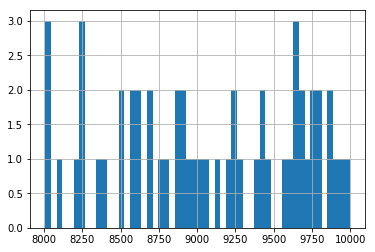

In [189]:
%matplotlib inline
data.groupby(['category_id']).size().hist(bins=54)

The data sample is balanced, the number of representatives of each class is approximately equal.

Let's perform cross-validation procedure to assess the quality of the model. The quality on the test sample will be recorded for each level of the category hierarchy.

In [81]:
# Generator object for obtaining sets of indices for training and for checking the 
# quality of the model at each iteration of cross-validation
skf = StratifiedKFold(n_splits=10, random_state=42)

In [128]:
accuracies_cv_data = pd.DataFrame(columns=['CV_iteration'] + 
                                          ['Acc_level_{0}'.format(i) for i in range(0, 4)])
cv_iteration = 1

for train_index, test_index in skf.split(data[['description']], data['ft_category_id']):

    X_train, X_test = data[['description']].iloc[train_index], data[['description']].iloc[test_index]
    y_train, y_test = data['ft_category_id'].iloc[train_index], data['ft_category_id'].iloc[test_index]
    
    X_train['ft_category_id'] = y_train
    X_test['ft_category_id'] = y_test
    
    # Save train dataset to file
    X_train.loc[:, ['ft_category_id', 'description']].to_csv('data_final_train_cv.txt', 
                                                             header=False,
                                                             sep=' ',
                                                             index=None, 
                                                             quoting=csv.QUOTE_NONE, 
                                                             escapechar=' ')
    
    # Create fastText model
    model = ft.train_supervised('data_final_train_cv.txt', 
                                epoch=15, 
                                wordNgrams=3, 
                                dim=150,
                                thread=4)
    
    # Prediction for test data
    X_test['predicted_id'] = X_test['description'].apply(lambda s: model.predict(s.strip())[0][0])
    
    # Calculate model quality for different category levels
    acc_level_3 = accuracy_score(X_test['ft_category_id'], X_test['predicted_id'])
    
    acc_level_2 = accuracy_score(X_test['ft_category_id'].map(cat_id_dict['Level_2']), 
                                 X_test['predicted_id'].map(cat_id_dict['Level_2']))
    
    acc_level_1 = accuracy_score(X_test['ft_category_id'].map(cat_id_dict['Level_1']), 
                                 X_test['predicted_id'].map(cat_id_dict['Level_1']))

    acc_level_0 = accuracy_score(X_test['ft_category_id'].map(cat_id_dict['Level_0']), 
                                 X_test['predicted_id'].map(cat_id_dict['Level_0']))
    
    accuracies_cv_data.loc[cv_iteration] = [cv_iteration,
                                            acc_level_0,
                                            acc_level_1,
                                            acc_level_2,
                                            acc_level_3]
   
    print("""CV iteration: {0}, test accuracy = {1:.5f}""".format(cv_iteration, acc_level_3))
       
    cv_iteration += 1


CV iteration: 1, test accuracy = 0.88307
CV iteration: 2, test accuracy = 0.87932
CV iteration: 3, test accuracy = 0.88157
CV iteration: 4, test accuracy = 0.88135
CV iteration: 5, test accuracy = 0.87878
CV iteration: 6, test accuracy = 0.87985
CV iteration: 7, test accuracy = 0.88098
CV iteration: 8, test accuracy = 0.88067
CV iteration: 9, test accuracy = 0.88277
CV iteration: 10, test accuracy = 0.88025


In [131]:
# CV results for all category levels
accuracies_cv_data

,CV_iteration,Acc_level_0,Acc_level_1,Acc_level_2,Acc_level_3
1,1.0,0.964720,0.946283,0.887850,0.883072
2,2.0,0.961429,0.941234,0.884000,0.879324
3,3.0,0.963076,0.943553,0.886534,0.881571
4,4.0,0.963420,0.944119,0.886154,0.881355
5,5.0,0.960615,0.940800,0.883582,0.878782
6,6.0,0.961755,0.942080,0.884896,0.879850
7,7.0,0.963385,0.943566,0.885456,0.880982
8,8.0,0.962054,0.943050,0.885569,0.880665
9,9.0,0.962273,0.942593,0.887536,0.882774
10,10.0,0.962617,0.941790,0.885644,0.880248


In [132]:
# Average CV results for all category levels
accuracies_cv_data.drop('CV_iteration', axis=1).mean(axis=0)

Acc_level_0    0.962534
Acc_level_1    0.942907
Acc_level_2    0.885722
Acc_level_3    0.880862
dtype: float64

#### 5.Use all available labeled data to retrain the model, make a predictions for control dataset

Now let's train the model with the same hyperparameters on all labeled data.

In [135]:
data.loc[:, ['ft_category_id', 'description']].to_csv('data_final_train.txt', 
                                                             header=False,
                                                             sep=' ',
                                                             index=None, 
                                                             quoting=csv.QUOTE_NONE, 
                                                             escapechar=' ')

In [136]:
model = ft.train_supervised('data_final_train.txt', 
                            epoch=15, 
                            wordNgrams=3, 
                            dim=150,
                            thread=4)

Preprocessing for the control data according to the scheme similar to the one above

In [159]:
control_data = pd.read_csv('data/test.csv')

In [160]:
control_data.head()

,item_id,title,description,price
0,489517,Стоик журнальный сталь,продам журнальный столик изготавливаю столы из...,10000.0
1,489518,iPhone 5 64Gb,"Телефон в хорошем состоянии. Комплект, гаранти...",12500.0
2,489519,Утеплитель,ТЕПЛОПЕЛЕН-ЛИДЕР ТЕПЛА!!! Толщина утеплителя :...,250.0
3,489520,Пальто демисезонное,Продам пальто женское (букле) в отличном состо...,1700.0
4,489521,Samsung syncmaster T200N,"Условно рабочий, проблема в панели настройки м...",1000.0


In [161]:
control_data['description'] = control_data['title'] + ' ' + control_data['description']
control_data.drop(['title', 'price'], axis=1, inplace=True)

In [163]:
%%time
control_data['description'] = control_data['description'].apply(lambda s: normalize(s))

CPU times: user 2min 29s, sys: 7.84 s, total: 2min 37s
Wall time: 11min 19s


In [164]:
control_data['description'] = control_data['description'].apply(lambda text: 
                                                " ".join([token for token in text.split(' ') 
                                                if token not in CUSTOM_STOPWORDS]))

In [165]:
control_data.head()

,item_id,description
0,489517,стоик журнальный сталь продавать журнальный ст...
1,489518,iphone телефон состояние комплект гарантия сал...
2,489519,утеплитель теплопельный лидер тепло толщина ут...
3,489520,пальто демисезонный продавать пальто женский б...
4,489521,samsung syncmaster t200n условно рабочий пробл...


Predictions for control dataset

In [168]:
control_data['category_id'] = control_data['description'].apply(lambda s: 
                                                                model.predict(s.strip())[0][0])

In [169]:
control_data.head()

,item_id,description,category_id
0,489517,стоик журнальный сталь продавать журнальный ст...,__label__22
1,489518,iphone телефон состояние комплект гарантия сал...,__label__0
2,489519,утеплитель теплопельный лидер тепло толщина ут...,__label__15
3,489520,пальто демисезонный продавать пальто женский б...,__label__33
4,489521,samsung syncmaster t200n условно рабочий пробл...,__label__13


Save predictions to file

In [175]:
control_data['category_id'] = control_data['category_id'].apply(lambda s: int(s[9:]))

In [179]:
control_data.loc[:, ['item_id', 'category_id']].to_csv("control_result.csv", index=None)